In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data and sort chronologically

work = pd.read_csv("../augmento_BTC_24h.csv")
work = work.sort_values(by="Date", ascending=True)
work = work.reset_index()

sizePar = 10

<Figure size 1440x720 with 0 Axes>

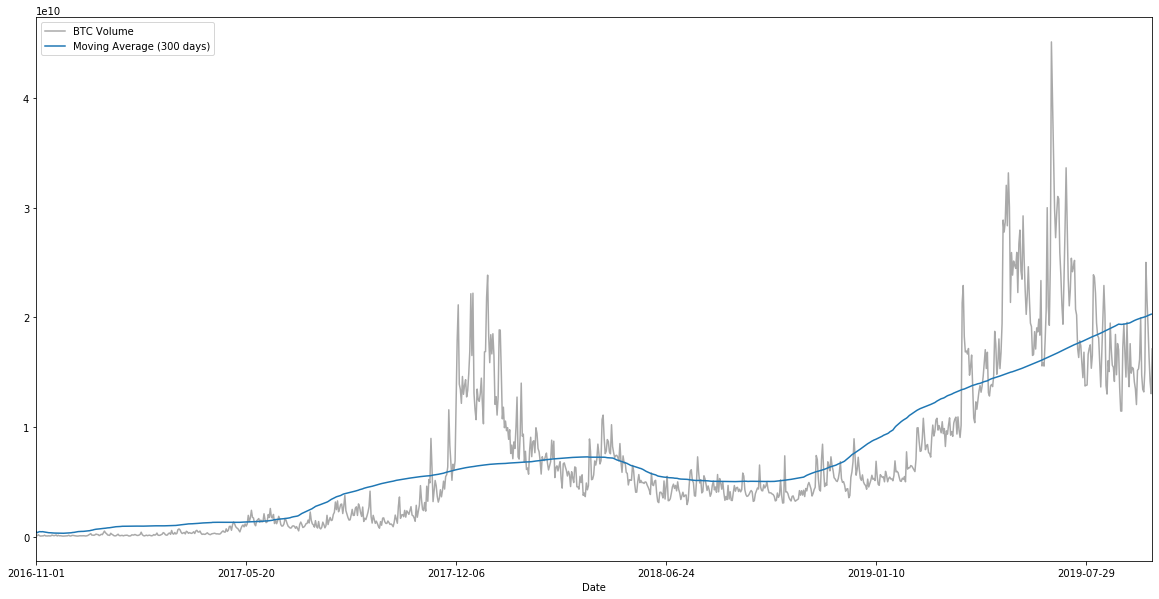

In [3]:
#work = work[["Date", "BTC_Volume", "BTC_"]]
work["Vol"] = work.BTC_Volume
work["Vol-25"] = work.BTC_Volume.shift(-50)
work["Vol_MA"] = work["Vol-25"].rolling(100, min_periods=25).mean() # first 24 dates are omitted
#work["Vol_MA"] = work["Vol-25"].rolling(100, min_periods=1).mean()

work["Vol-25"] = work.BTC_Volume.shift(-150)
work["Vol_MA"] = work["Vol-25"].rolling(300, min_periods=1).mean()


fig1 = plt.figure(figsize = (sizePar*2, sizePar))

ax = work.plot(x="Date", y="BTC_Volume", color="DarkGrey", label="BTC Volume", figsize=(sizePar*2, sizePar))
work.plot(x="Date", y="Vol_MA", label="Moving Average (300 days)", ax=ax)

plt.savefig('volumeMA.png', dpi=300, transparent=True)

In [4]:
work["ImagDay"] = work["Vol"] / work["Vol_MA"]
work["ImagDays"] = work["ImagDay"].cumsum()

print(int(work["ImagDays"].max(0)), "imaginary days vs.", work.index.max(), "real days \n")
print("Note that 24 real days excl. by design")
print(work["ImagDay"].describe())

871 imaginary days vs. 1063 real days 

Note that 24 real days excl. by design
count    1064.000000
mean        0.818732
std         0.521885
min         0.062853
25%         0.490531
50%         0.760306
75%         1.004002
max         3.628011
Name: ImagDay, dtype: float64


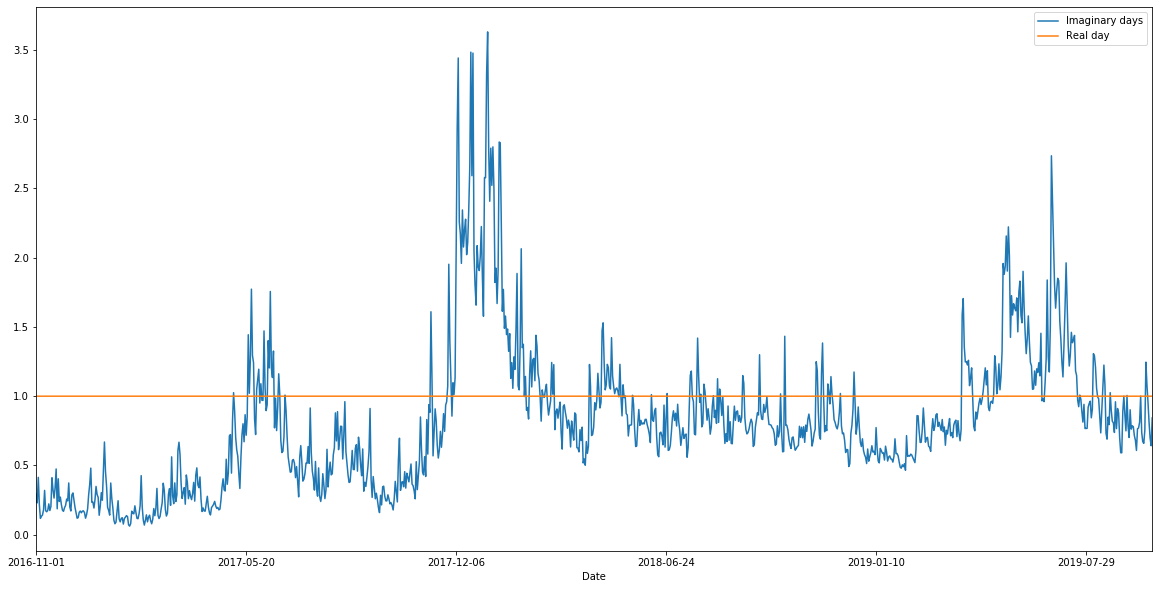

In [5]:
work["one"] = 1

#work.plot(x="Date", y="ImagDay", label="Imaginary day", figsize=(sizePar, sizePar/2))
ax = work.plot(x="Date", y="ImagDay", label="Imaginary days", figsize=(sizePar*2, sizePar))
work.plot(x="Date", y="one", label="Real day", ax=ax)

In [6]:
work["ImagDaysFull"] = np.ceil(work["ImagDays"])

imagData = pd.DataFrame()
imagData["imagDay"] = pd.Series(range(0, 1039))

#imagData["im"]

In [7]:
ImagData = work[work.ImagDay > 0].copy().\
drop(columns="index").reset_index(drop=True)

ImagDataS =  pd.concat([ImagData["ImagDaysFull"], ImagData.iloc[:, 3:96]], axis=1)
ImagDataR =  pd.concat([ImagData.iloc[:, 1:2], ImagData.iloc[:, 96:]], axis=1)

In [8]:
ImagDataNew = pd.concat([ImagDataR.groupby('ImagDaysFull').mean(),
                         ImagDataS.groupby('ImagDaysFull').sum()], axis=1).\
drop(columns=["Vol-25", "ImagDay", "one"]).\
reset_index()

#ImagDataNew

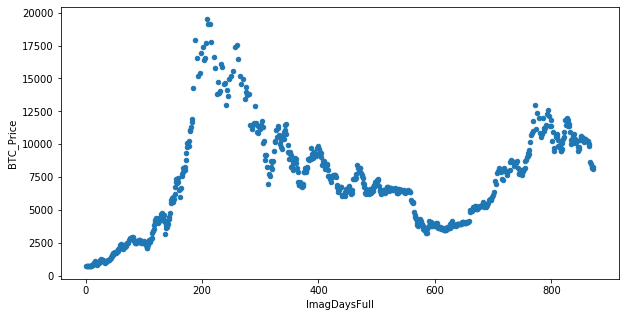

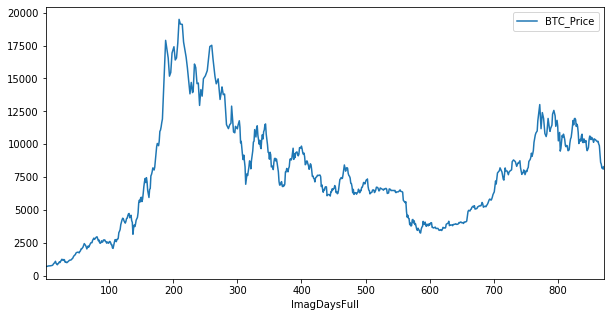

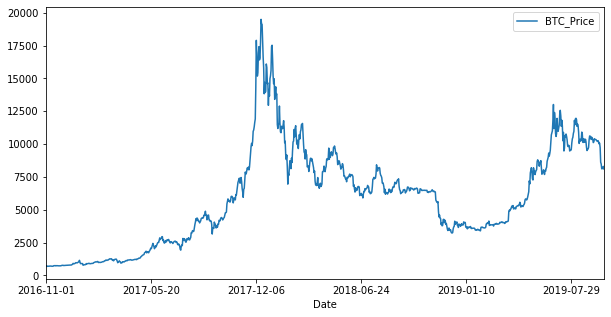

In [9]:
ImagDataNew.plot.scatter(x="ImagDaysFull", y="BTC_Price", figsize=(sizePar, sizePar/2))
ImagDataNew.plot(x="ImagDaysFull", y="BTC_Price", figsize=(sizePar, sizePar/2))
work.plot(x="Date", y="BTC_Price", figsize=(sizePar, sizePar/2))

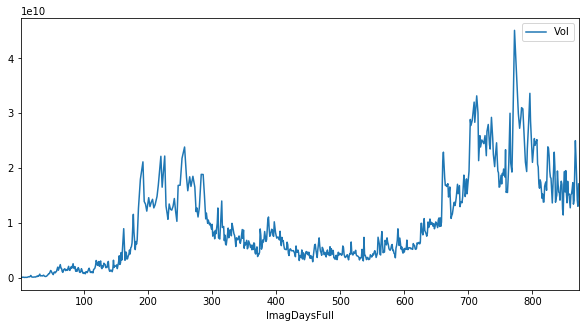

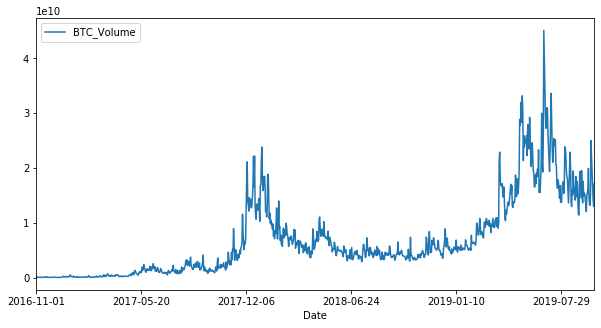

In [10]:
ImagDataNew.plot(x="ImagDaysFull", y="Vol", figsize=(sizePar, sizePar/2))
work.plot(x="Date", y="BTC_Volume", figsize=(sizePar, sizePar/2))

count    739.000000
mean       0.002085
std        0.049643
min       -0.286304
25%       -0.018124
50%        0.003985
75%        0.027473
max        0.201579
Name: BTC_Price_diff, dtype: float64

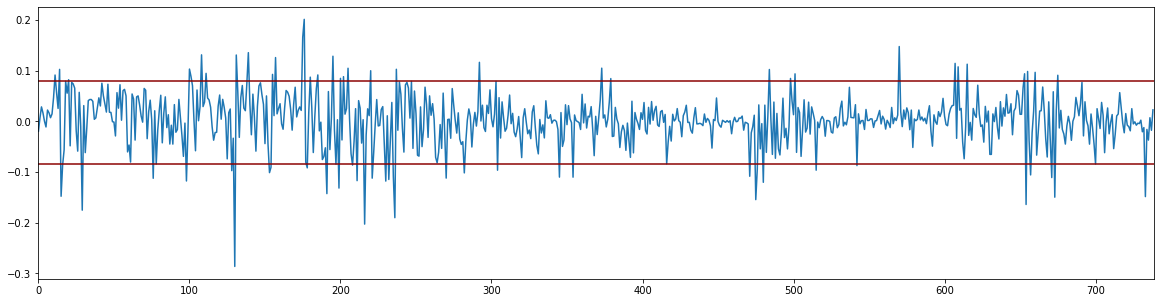

In [11]:
ImagDataNew["BTC_Price+1"] = ImagDataNew["BTC_Price"].shift(-1)
ImagDataNew["BTC_Price_diff"] = (ImagDataNew["BTC_Price+1"] - ImagDataNew["BTC_Price"]) / ImagDataNew["BTC_Price+1"]
ImagDataNew["BTC_Price_diff_95"] = ImagDataNew["BTC_Price_diff"].quantile(.95)
ImagDataNew["BTC_Price_diff_05"] = ImagDataNew["BTC_Price_diff"].quantile(.05)

fig1 = plt.figure(figsize = (sizePar*2, sizePar/2))

#ax = ImagDataNew.reset_index().plot(y="BTC_Price_diff", x="index", label="Relative difference in BTC Price", figsize=(sizePar*2, sizePar/2))
ax = ImagDataNew.BTC_Price_diff.plot(figsize=(sizePar*2, sizePar/2))#, style=".")
ax = ImagDataNew.BTC_Price_diff_05.plot(figsize=(sizePar*2, sizePar/2), ax=ax, color="DarkRed")
ax = ImagDataNew.BTC_Price_diff_95.plot(figsize=(sizePar*2, sizePar/2), ax=ax, color="DarkRed")

plt.savefig('relpricediff_imaginary.png', dpi=300, transparent=True)

ImagDataNew.BTC_Price_diff.describe()#quantile(.25)

In [12]:
ImagDataNew_High = ImagDataNew[ImagDataNew.BTC_Price_diff > ImagDataNew["BTC_Price_diff"].quantile(.95)]
ImagDataNew_Low = ImagDataNew[ImagDataNew.BTC_Price_diff < ImagDataNew["BTC_Price_diff"].quantile(.05)]

print(round(len(ImagDataNew_High) * 2 * 100 / len(ImagDataNew), 2), "% of all imaginary days considered outliers")

10.0 % of all imaginary days considered outliers


In [13]:
def Comparison(outl, data):
    #x = (outl.mean() - data.mean()) / data.mean()
    x = outl.mean() / data.mean()
    x = x.sort_values(ascending=False)
    print("> 5 highest values:")
    print(round(x[:5], 4), "\n")
    print("> 5 lowest values:")
    print(round(x[-5:], 4), "\n")
    print("Mean is", x.mean().round(4))
    #return(x)

In [14]:
Comparison(ImagDataNew_Low.iloc[:, 5:98], ImagData.iloc[:, 3:96])

> 5 highest values:
Flippening    2.7943
Correction    2.1953
Rebranding    2.1132
FUD_theme     2.1090
Fees          2.0943
dtype: float64 

> 5 lowest values:
Leverage      1.4620
Volume        1.4539
Governance    1.4146
Stablecoin    1.0799
ETF           0.8458
dtype: float64 

Mean is 1.755


In [15]:
Comparison(ImagDataNew_High.iloc[:, 5:98], ImagData.iloc[:, 3:96])

> 5 highest values:
Pump_and_dump    2.3356
Correction       2.1330
FOMO_theme       2.1086
Happy            2.0616
FOMO             2.0561
dtype: float64 

> 5 lowest values:
Volume             1.4713
Token_economics    1.4318
Governance         1.4146
ETF                0.9886
Stablecoin         0.9881
dtype: float64 

Mean is 1.7579
